# Semantic Segmentation of Water using U-Net
# Part 4 - Data Augmentation


In this part I will build a larger training dataset by applying data augmentation techniques to the original images.

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, save_img
import numpy as np
import json, os
from random import shuffle
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import warnings
import re
import time

In [2]:
from unetlib.preprocessing import get_lakes_with_masks, make_dataframes_for_flow
import unetlib.visualisation as vs

In [3]:
# Imagery directories
nwpu_data_dir = 'nwpu_lake_images/data/'
nwpu_mask_dir = 'nwpu_lake_images/masks/'

In [4]:
# Split the test/train data
train_img_df, train_msk_df, test_img_df, test_msk_df, = make_dataframes_for_flow(nwpu_data_dir,
                                                                                 nwpu_mask_dir,
                                                                                 test_split=0.25,
                                                                                 random_state=42
                                                                                )

## Data Augmentation with Numpy & Pillow
Data augmentations are any transformation that can be applied to the data (images in this case) to produce a new version of the data. These transformations can include flipping the image, zooming in/out, skewing, rotating etc.

The aim is to create new images that still look like the training data but have appropriate variation that one might expect in the real world. For example it makes sense to rotate and flip the lake images because they can exist in a huge range of shapes and sizes. On the other hand, consider OCR - flipping the images would flip the characters which then would lose meaning and not really represent the real world input data to the model.

These new images provide more data and more variation than the original dataset allowing the network to learn to generalise better. In this respect augmentation acts as a sort of regulariser.

To illustrate, I'll apply some random transformations to an image and show the output. The Pillow library contains useful functions for doing this.

In [5]:
# Select a random image
rand_img = train_img_df.sample(1)
rand_img_fn = os.path.join(nwpu_data_dir, rand_img.filename.squeeze())
print(rand_img_fn)

nwpu_lake_images/data/lake_567.jpg


Augmentations:
	Horizontal Flip: False
	Vertical Flip: False
	Rotation: 40


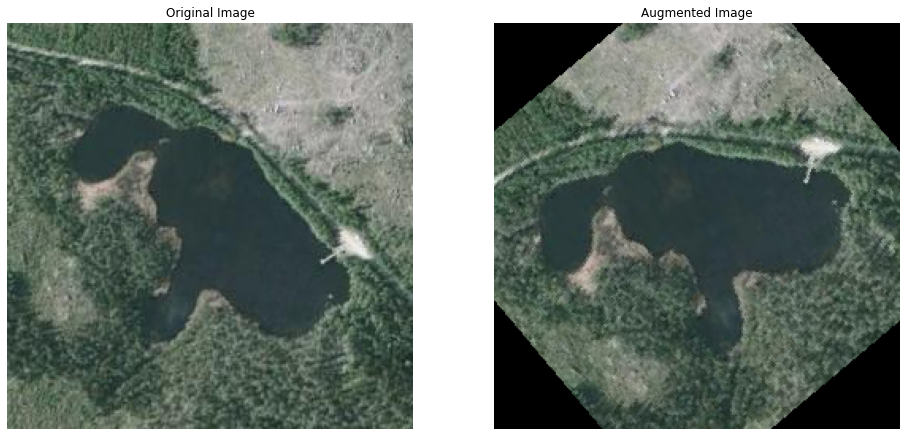

In [6]:
# Define a few augmentations
hflip = np.random.choice([True,False])
vflip = np.random.choice([True,False])
rot = np.random.choice(range(30,80,10))

print(f'Augmentations:\n\tHorizontal Flip: {hflip}'
      f'\n\tVertical Flip: {vflip}\n\tRotation: {rot}'
     )

# Open image
img = Image.open(rand_img_fn)

# Create axes and plot original
fig, axes = plt.subplots(1,2,figsize=(16,8))
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title('Original Image')

# Apply augmentations
if hflip:
    img = img.transpose(Image.FLIP_TOP_BOTTOM)
if vflip:
    img = img.transpose(Image.FLIP_LEFT_RIGHT)
img = img.rotate(rot)

# Plot the augmented image
axes[1].imshow(img)
axes[1].axis('off')
axes[1].set_title('Augmented Image');

The resulting image looks like a reasonable training sample. Note that, the corresponding mask needs to have the same augmentations applied to ensure the correct ground truth labels are maintained.

Due to the rotation there is information loss at the edges of the new image; these pixels have been assigned a value of 0. To counter this, and avoid the network training on these values, the pixels should be assigned a value based on the image e.g. nearest neighbour. Thankfully Keras has functionality that will streamline this process.

## Data Augmentation with Keras
Recall from Part 2 that the training and validation generators are configured using the `ImageDataGenerator` class. There are a range of parameters that this generator accepts and uses to apply augmentations such as those above. Previously I only used the `validation_split` and `rescale` parameters - I'll now expand this setup to include augmentations.

In [7]:
# Instantiate the data generator
datagen = ImageDataGenerator(validation_split=0.3,
                             rotation_range=90,       # Rotate images between 0 and 90 degrees
                             horizontal_flip=True,    # Flip images on horizontal axis
                             vertical_flip=True,      # Flip images on vertical axis
                             width_shift_range=0.15,  # Shift images by up to 15% along the horizontal axis
                             height_shift_range=0.15, # Shift images by up to 15% along the vertical axis
                             zoom_range=0.25,         # Zoom images in/out by up to 25%
                             rescale=1/255.
                            )

In [8]:
# The image and mask flows are created in the same way as before
aug_train_img = datagen.flow_from_dataframe(train_img_df,nwpu_data_dir,subset='training',
                                            class_mode=None,shuffle=False, seed=42)
aug_train_msk = datagen.flow_from_dataframe(train_msk_df,nwpu_mask_dir,subset='training',
                                            class_mode=None, shuffle=False, seed=42)

Found 210 validated image filenames.
Found 210 validated image filenames.


In [9]:
# Get the first batch
aug_train_img_batch = aug_train_img.next()
aug_train_msk_batch = aug_train_msk.next()

I'll plot the image and mask pairs to make sure that the masks still match after the augmentations.

In [10]:
def plot_batch(img_batch, msk_batch=None, n_images=None, n_cols=2,
               figsize=(20, 10)):
    """Plot batch of images

    Parameters
    ----------
    img_batch: numpy.ndarray or tensorflow.Tensor
        Batch of images. Dimensions should be (N, H, W, C).
    msk_batch: numpy.ndarray or tensorflow.Tensor, optional
        Batch of mask images corresponding to each image in
        `img_batch`.
    n_images: int, optional
        Number of images (or image/mask pairs) to plot. By
        default all images are plotted.
    n_cols: int, default=2
        Number of columns in plot. Number of rows will be
        determined from this.
    figsize: tuple of int, default=(20, 10)
        Width and height of figure in inches.
    """
    # Batches must be of dimensions N,H,W,C
    assert img_batch.ndim == 4

    if msk_batch is not None:
        assert msk_batch.ndim == 4
        
        # Batches must contain the same number of images.
        assert len(img_batch) == len(msk_batch)

        # Interleave masks with images
        img_batch = np.insert(img_batch, np.arange(1, len(msk_batch) + 1),
                              msk_batch, axis=0)

        # Double n_images to account for masks
        n_images *= 2
    
    # Set number of rows
    n_rows = int(np.ceil(n_images / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.ravel()
    
    for i, ax in zip(range(n_images), axes):
        img = img_batch[i]
        cmap = None
        if img.shape[-1] == 1:
            img = img[:, :, 0]
            cmap='gray'
        
        ax.imshow(img, cmap=cmap)
        ax.axis('off')
        
    # Turn off any axes that do not have data
    for ax in axes:
        if not ax.has_data():
            ax.axis('off')

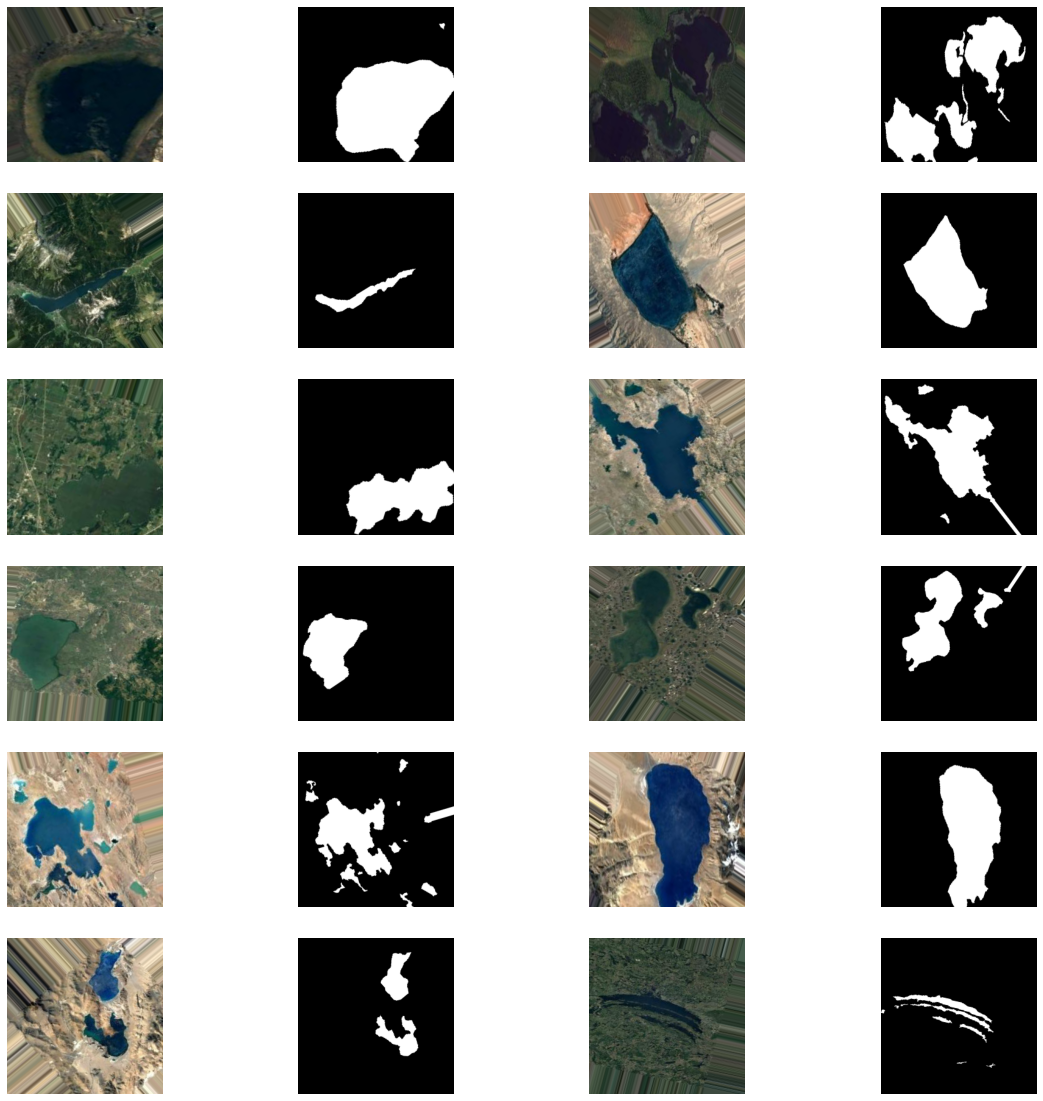

In [11]:
plot_batch(aug_train_img_batch, aug_train_msk_batch, n_images=12, n_cols=4, figsize=(20,20))

Now I can easily and consitently apply augmentations to the data. Since I'm still using a single datagen object this means that both the training and validation data will have augmentations applied.

In [12]:
# Generate some validation data
aug_val_img = datagen.flow_from_dataframe(train_img_df,nwpu_data_dir,subset='validation',
                                            class_mode=None,shuffle=False, seed=42)
aug_val_msk = datagen.flow_from_dataframe(train_msk_df,nwpu_mask_dir,subset='validation',
                                            class_mode=None, shuffle=False, seed=42)

Found 90 validated image filenames.
Found 90 validated image filenames.


In [13]:
# Get the first batch
aug_val_img_batch = aug_val_img.next()
aug_val_msk_batch = aug_val_msk.next()

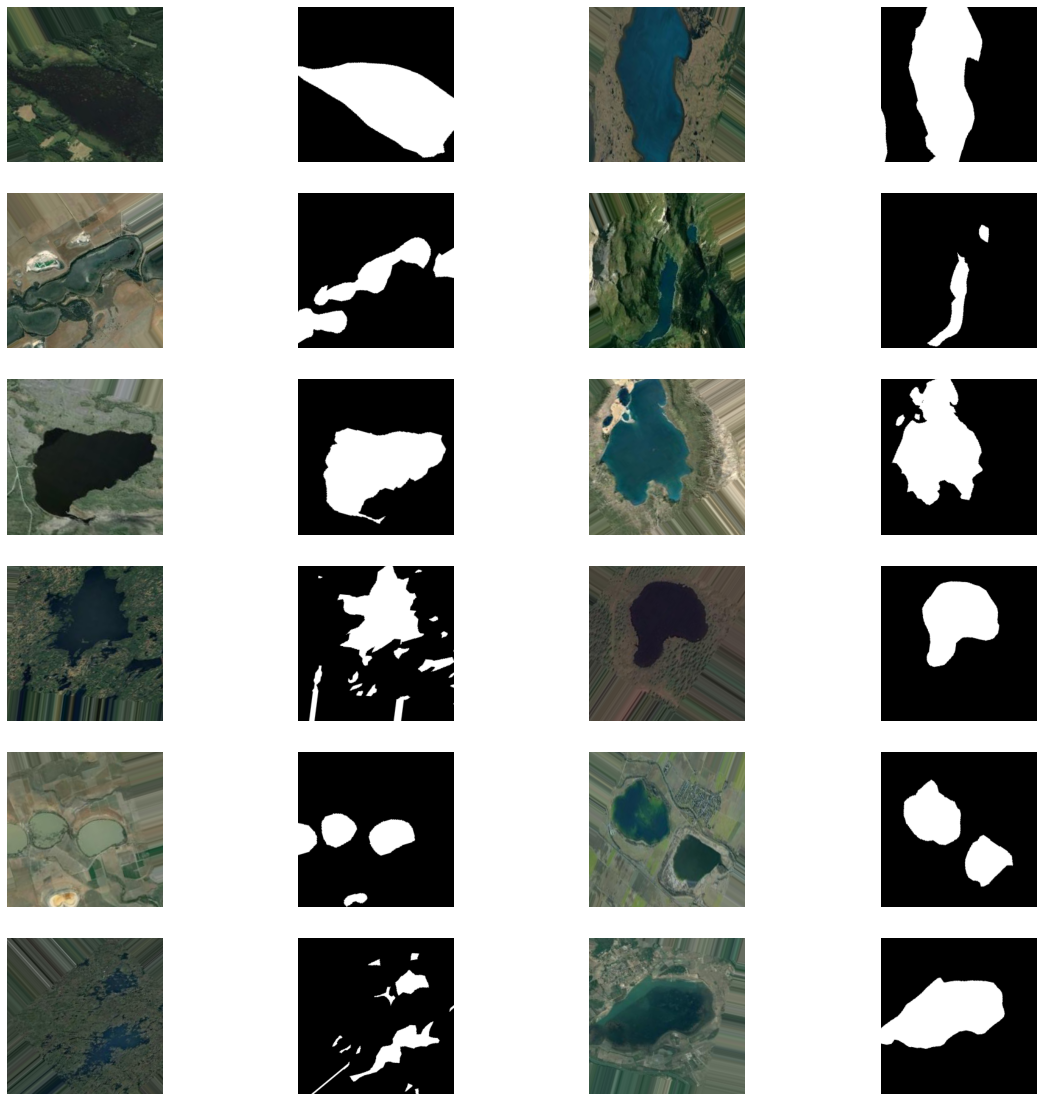

In [14]:
plot_batch(aug_val_img_batch, aug_val_msk_batch, 12, 4, figsize=(20,20))

<div class="alert alert-block alert-info"><b>Note:</b><br>It looks like the same augmentations that are applied to the training images are also applied to the validation images. This is due to the same seed being used in the calls to <code>flow_from_dataframe</code>.
</div>

When using this kind of image augmentation on-the-fly i.e. augmented images are generated as part of the training process, the validation data should not be augmented. If it is, then the validation data will not be consisent between the batches and epochs so it is difficult to get a good measure of the model's performance. Therefore a separate data generator should be used.

The validation data could instead be augmented before training and written to disk. Then it can be used consistently for evaluation. I wont look into this here but it could be an interesting experiment. Instead I will set up a separate `ImageDataGenerator` to handle the validation data.

In [15]:
# Create training datagen
datagen_train = ImageDataGenerator(validation_split=0.3, # Split the data but i will only use training subset
                                   rotation_range=90,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   zoom_range=0.25,
                                   rescale=1/255.
                                  )

# Create validation datagen
datagen_val = ImageDataGenerator(validation_split=0.3, # Split the data but i will only use valiation subset
                                 rescale=1/255.
                                )

In [16]:
# Create the new training flows
aug_train_img2 = datagen_train.flow_from_dataframe(train_img_df,nwpu_data_dir,subset='training',
                                            class_mode=None,shuffle=False, seed=42)
aug_train_msk2 = datagen_train.flow_from_dataframe(train_msk_df,nwpu_mask_dir,subset='training',
                                            class_mode=None, shuffle=False, seed=42)

Found 210 validated image filenames.
Found 210 validated image filenames.


In [18]:
# Create the new training batches
aug_train_img_batch2 = aug_train_img2.next()
aug_train_msk_batch2 = aug_train_msk2.next()

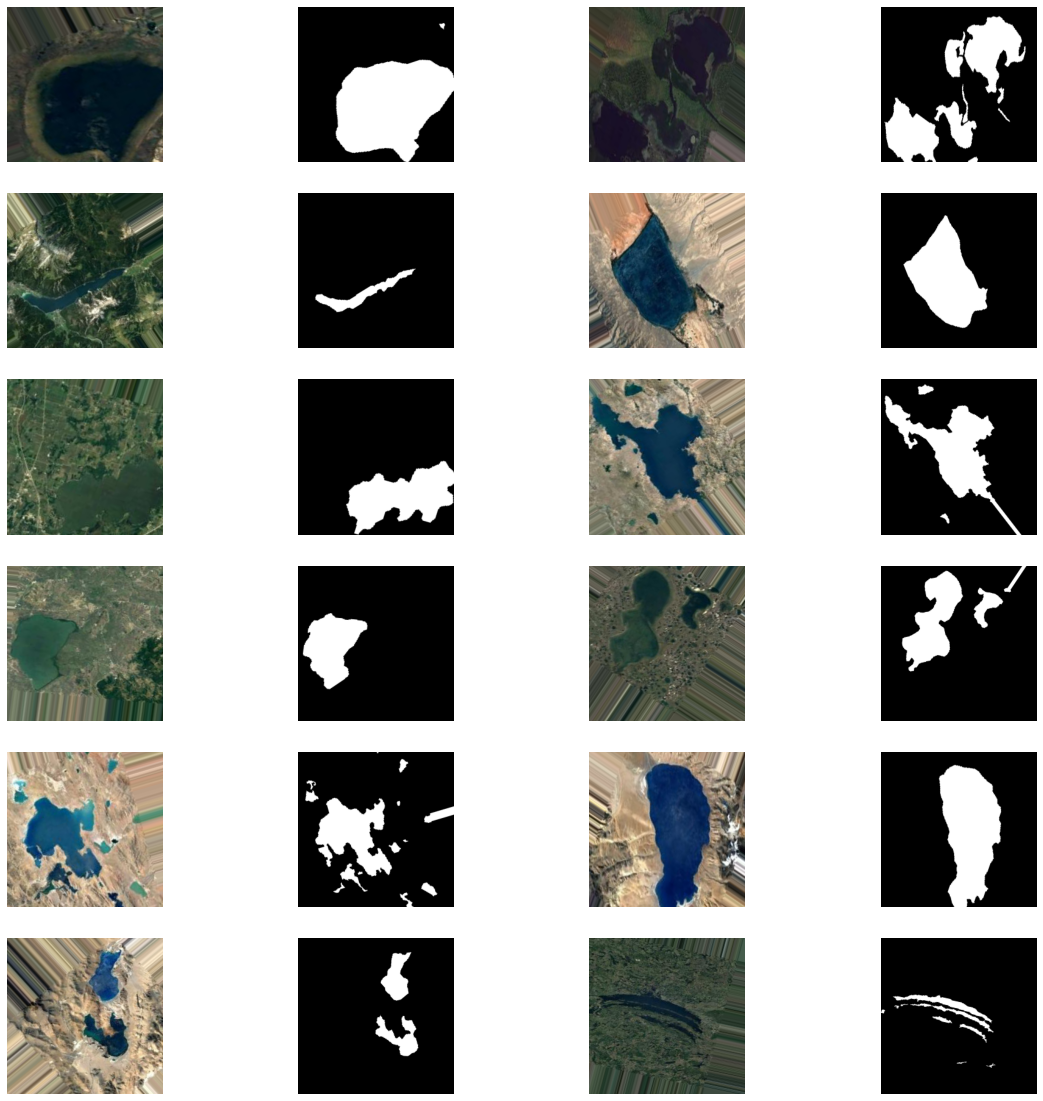

In [19]:
plot_batch(aug_train_img_batch2, aug_train_msk_batch2, 12, 4, figsize=(20,20))

In [20]:
aug_train_img.filenames == aug_train_img2.filenames

True

In [21]:
aug_train_msk.filenames == aug_train_msk2.filenames

True

The training data is the same as earlier since nothing has changed in that respect. The validation data however should show that no augmentations have been applied.

In [22]:
# Create the new validation flows - no seed required since no shuffling or
# augmentations applied
val_img = datagen_val.flow_from_dataframe(train_img_df,nwpu_data_dir,subset='validation',
                                          class_mode=None,shuffle=False)

val_msk = datagen_val.flow_from_dataframe(train_msk_df,nwpu_mask_dir,subset='validation',
                                          class_mode=None, shuffle=False)

Found 90 validated image filenames.
Found 90 validated image filenames.


In [23]:
# Create the new validation batches
val_img_batch = val_img.next()
val_msk_batch = val_msk.next()

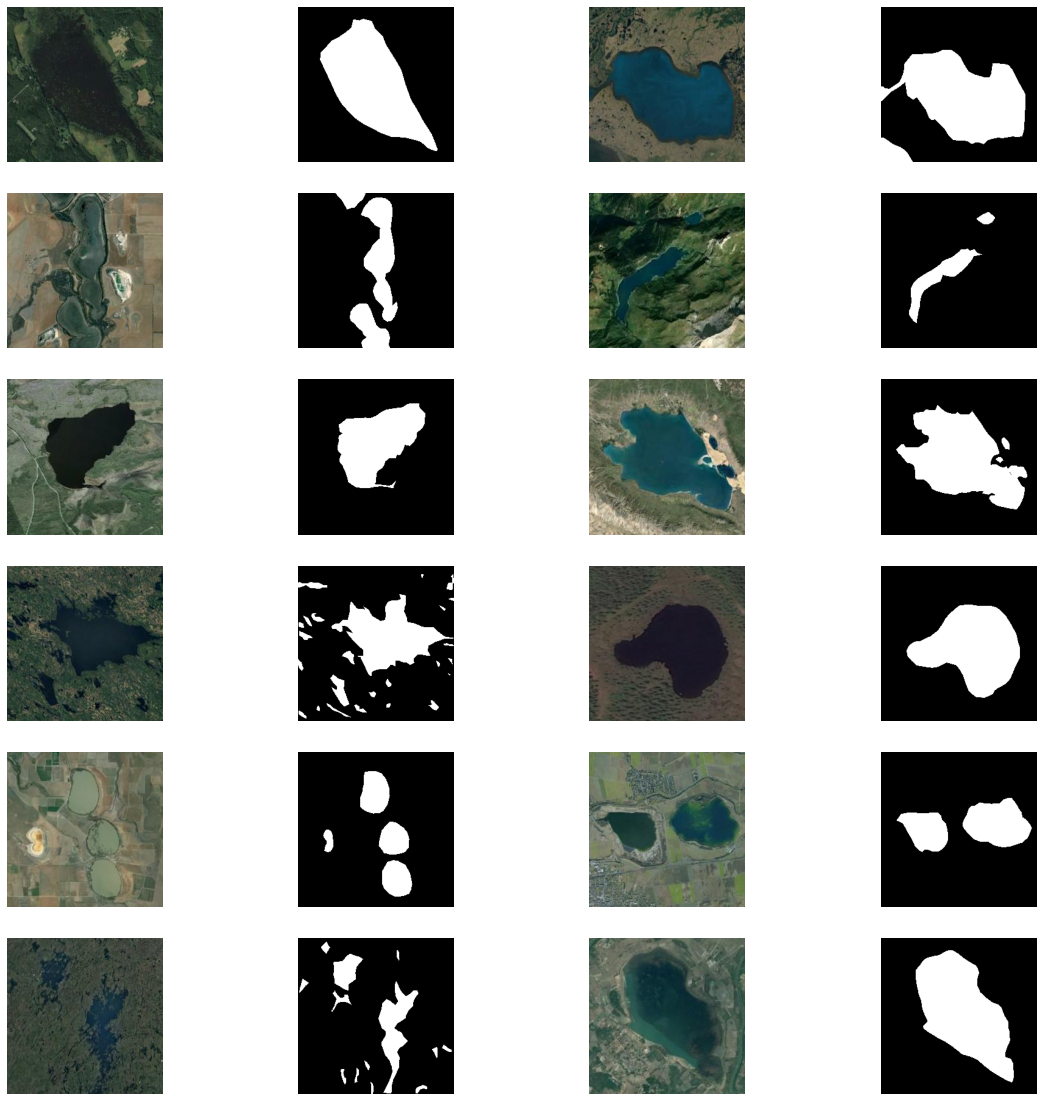

In [25]:
plot_batch(val_img_batch, val_msk_batch, 12, 4, figsize=(20,20))

In [26]:
aug_val_img.filenames == val_img.filenames

True

In [27]:
aug_val_msk.filenames == val_msk.filenames

True

The filenames in this validation set match those in the augmented set as expected. Further, it can be seen that in this case no augmention has been applied (verify agaist output above) - great!

To streamline this process of configuring separate data generators when applying augmentatons I'll expand my `make_data_generators` function. This is mostly the same as the function defined in Part 2 but here I add some paramaters for augmentation and create a separate validation generator if augmentations are being applied.

In [29]:
def make_data_generators(img_df, msk_df, img_dir, msk_dir, val_split=0.0,
                         batch_size=32, rescale=1/255, aug_dict=None,
                         aug_seed=None):
    """Create image & mask data generators.
    
    Optionally augmentation can be applied. Note that
    augmentations apply only to the training data not
    the validation data.
    
    The ordering of files in `img_df` and `msk_df` must match.
    For example, the first row of `msk_df` should correspond
    to the mask for the first image in `img_df`.

    If this is not the case the generators will fail to generate
    flows of matching image and mask pairs.
    
    Parameters
    ----------
    img_df, msk_df: pandas.core.frame.DataFrame
        DataFrames containing image and mask file names respectively.
        These must be stored in a `filename` column.
    img_dir, msk_dir: str
        Paths to image and mask directories.
    val_split: float, default=0.0
        Proportion of images to reserve for the validation set.
    batch_size: int, default=32
        Number of image/mask pairs in each batch.
    rescale: float, default=1/255
        Scaling to apply to image and mask data. Defaults to
        1/255 for rescaling 8bit unit data.
    aug_dict: dict, optional
        Keyword argument dictionary for augmentations.
        See `ImageDataGenerator` for valid keywords.
        Defaults to None resulting in no augmentations.
    aug_seed: int, optional
        Random seed for augmentations. Must be provided if
        use augmentations to maintain the alignment of images
        and masks. Only used if aug_dict specifies augmentations.
    
    Returns
    -------
    tuple of (generator, list):
        If val_split is 0, only the training data generator
        and file names are returned.
    tuple of (generator, generator, list, list):
        If val_split > 0, training and validation generators
        are returned along with the filenames used for each
        split. The returned order is training generator,
        validation generator, training file names, validation
        file names.
    """
    # Initialise the datagen arguments
    dg_init_args = {'validation_split': val_split}
    augment = aug_dict is not None and len(aug_dict) > 0
    if augment:
        # add the augmentation arguments if provided
        dg_init_args.update(aug_dict)
    
    # Instantiate the data generator
    datagen = ImageDataGenerator(**dg_init_args, rescale=rescale)
    
    # Create the training data image and mask flows
    # Note that the seed is used if augmentations are
    # being used
    train_img_gen = datagen.flow_from_dataframe(img_df,
                                                img_dir,
                                                y_col=None,
                                                class_mode=None,
                                                shuffle=None,
                                                subset='training',
                                                batch_size=batch_size,
                                                seed = aug_seed if augment else None
                                               )
    
    train_msk_gen = datagen.flow_from_dataframe(msk_df,
                                                msk_dir,
                                                y_col=None,
                                                class_mode=None,
                                                shuffle=None,
                                                subset='training',
                                                color_mode='grayscale',
                                                batch_size=batch_size,
                                                seed = aug_seed if augment else None
                                               )
    # Combine
    train_gen = (pair for pair in zip(train_img_gen, train_msk_gen))
    
    # If val_split is greater than 0, i.e. the data is actually split
    # create the validation data generators
    val_gen = None
    if val_split > 0:
        if augment:
            # Create new datagenerator for validation data if
            # training data is being augmented
            val_datagen = ImageDataGenerator(validation_split=val_split,
                                             rescale=rescale)
        else:
            # If no augmentations are applied to training data
            # resuse the training datagenerator
            val_datagen = datagen
            
        val_img_gen = val_datagen.flow_from_dataframe(img_df,
                                                      img_dir,
                                                      y_col=None,
                                                      class_mode=None,
                                                      shuffle=None,
                                                      subset='validation',
                                                      batch_size=batch_size
                                                     )

        val_msk_gen = val_datagen.flow_from_dataframe(msk_df,
                                                      msk_dir,
                                                      y_col=None,
                                                      class_mode=None,
                                                      shuffle=None,
                                                      subset='validation',
                                                      color_mode='grayscale',
                                                      batch_size=batch_size
                                                     )
        
        val_gen = (pair for pair in zip(val_img_gen, val_msk_gen))
        
    if val_gen is None:
        # If no split has been done just return train_gen and train filepaths
        return train_gen, train_img_gen.filepaths
    else:
        # Otherwise return train_gen and val_gen and also
        # the file paths that fall into each split
        
        train_fps = train_img_gen.filepaths
        val_fps = val_img_gen.filepaths
        
        return train_gen, val_gen, train_fps, val_fps

## Check Function Output
### With Augmentation

In [39]:
# Split the training data into train and validation generators
aug_dict = {'rotation_range':90,
            'horizontal_flip':True,
            'vertical_flip':True,
            'width_shift_range':0.15,
            'height_shift_range':0.15,
            'zoom_range':0.25
           }

train_gen, val_gen, train_fps, val_fps = make_data_generators(train_img_df, train_msk_df,
                                                              nwpu_data_dir, nwpu_mask_dir,
                                                              val_split=0.3, aug_dict=aug_dict,
                                                              aug_seed=42)

Found 210 validated image filenames.
Found 210 validated image filenames.
Found 90 validated image filenames.
Found 90 validated image filenames.


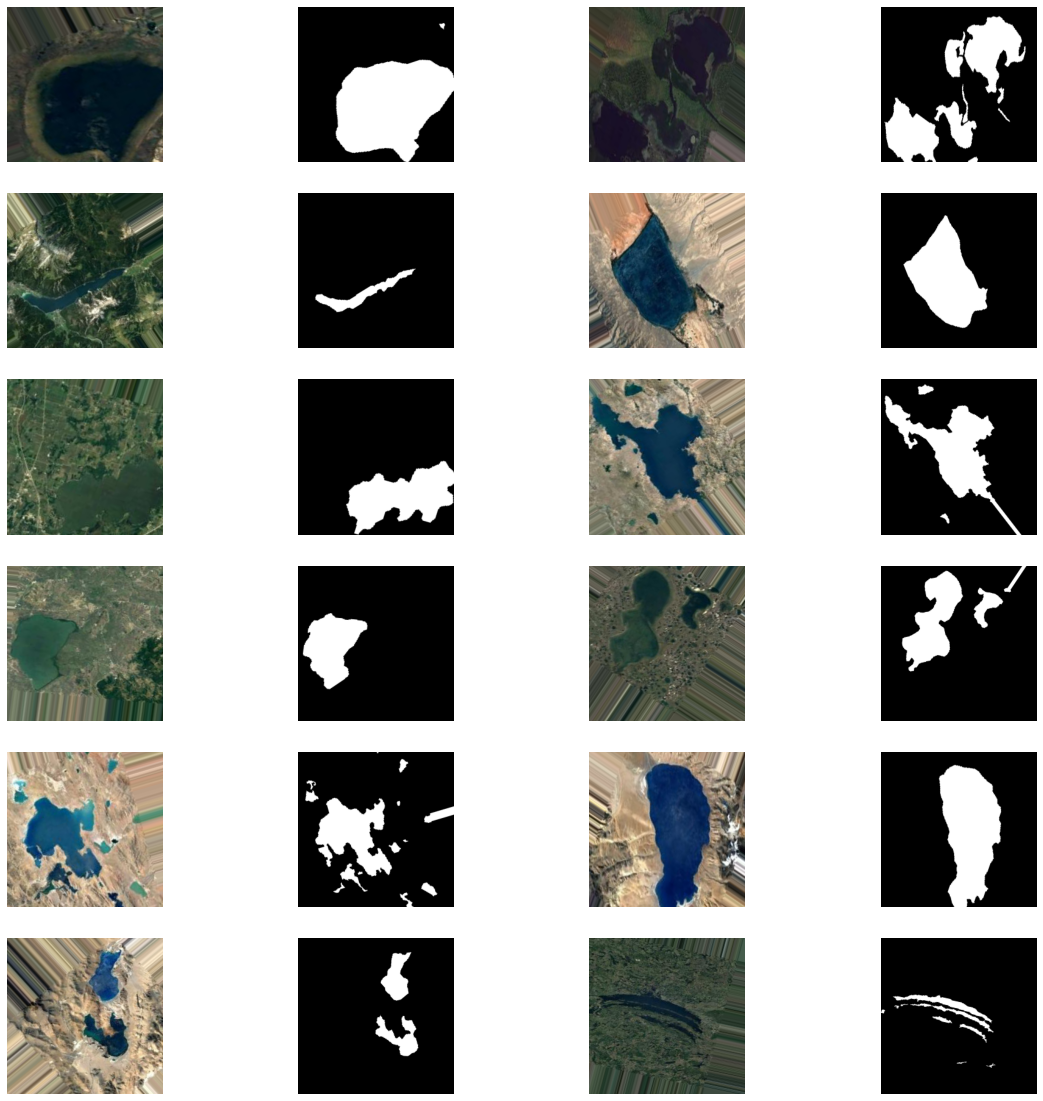

In [40]:
ti, tm = next(train_gen)
plot_batch(ti, tm,  12, 4, figsize=(20,20))

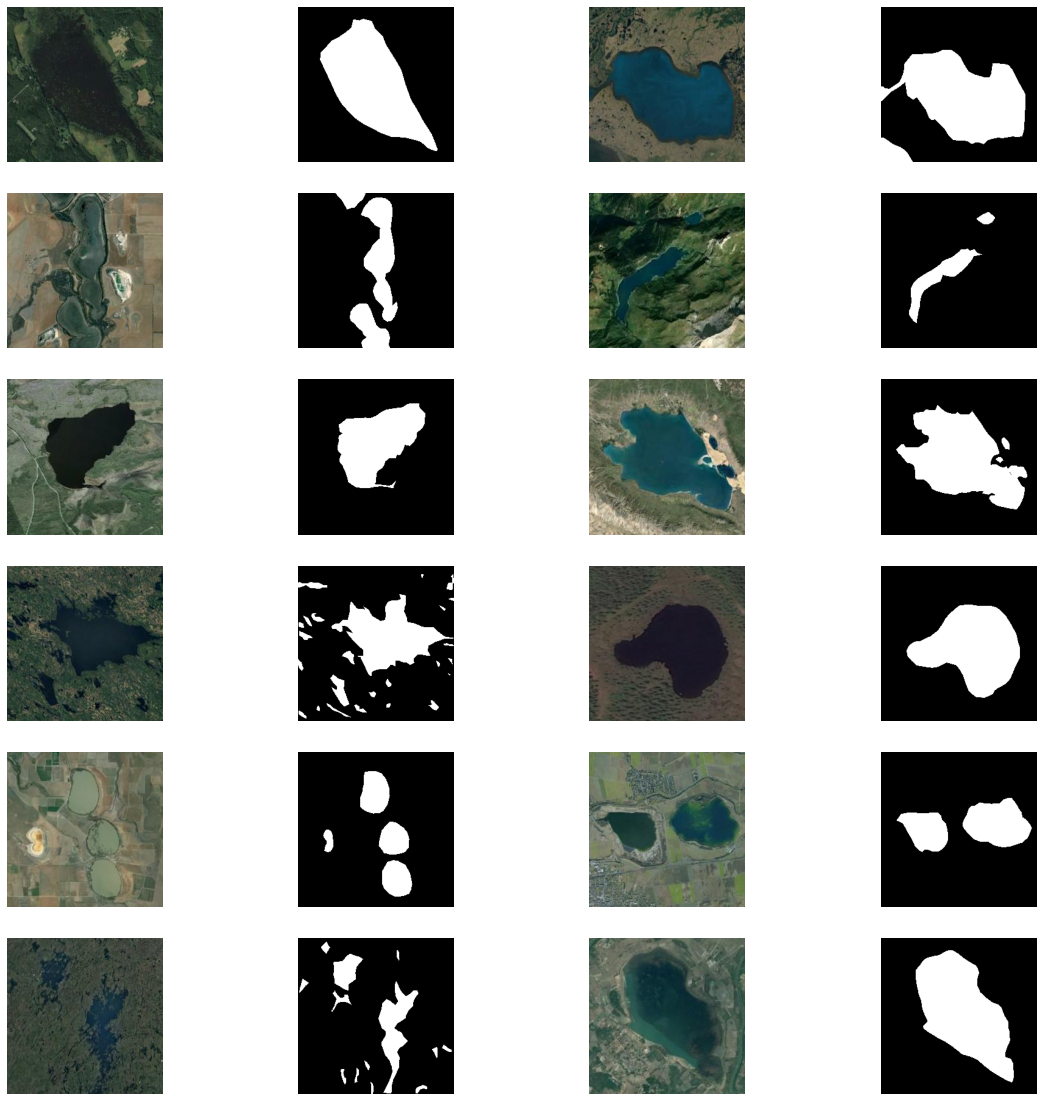

In [41]:
vi, vm = next(val_gen)
plot_batch(vi, vm,  12, 4, figsize=(20,20))

### Without Augmentation

In [36]:
# Test function without the augmentations
train_gen, val_gen, train_fps, val_fps = make_data_generators(train_img_df, train_msk_df,
                                                              nwpu_data_dir, nwpu_mask_dir,
                                                              val_split=0.3)

Found 210 validated image filenames.
Found 210 validated image filenames.
Found 90 validated image filenames.
Found 90 validated image filenames.


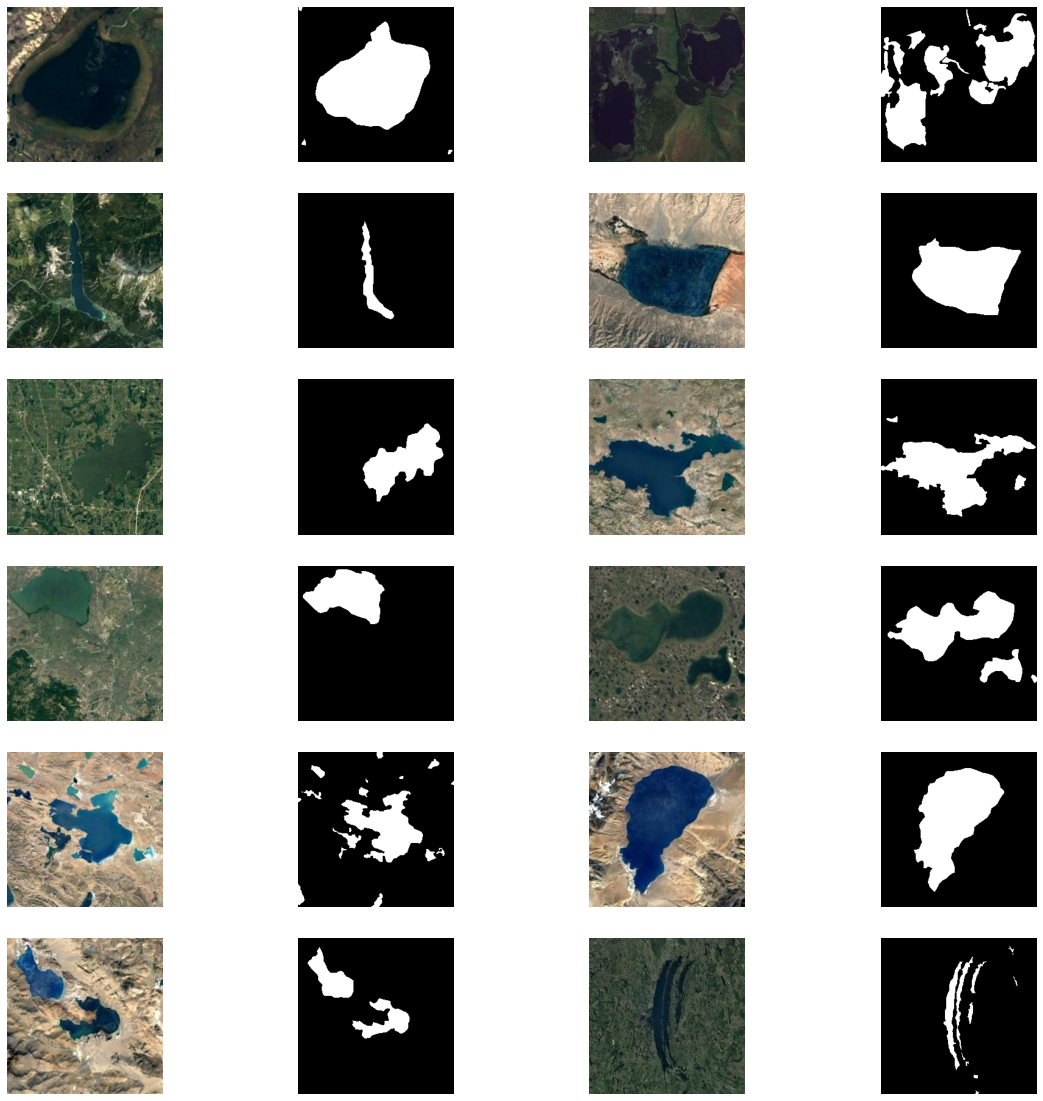

In [37]:
ti, tm = next(train_gen)
plot_batch(ti, tm,  12, 4, figsize=(20,20))

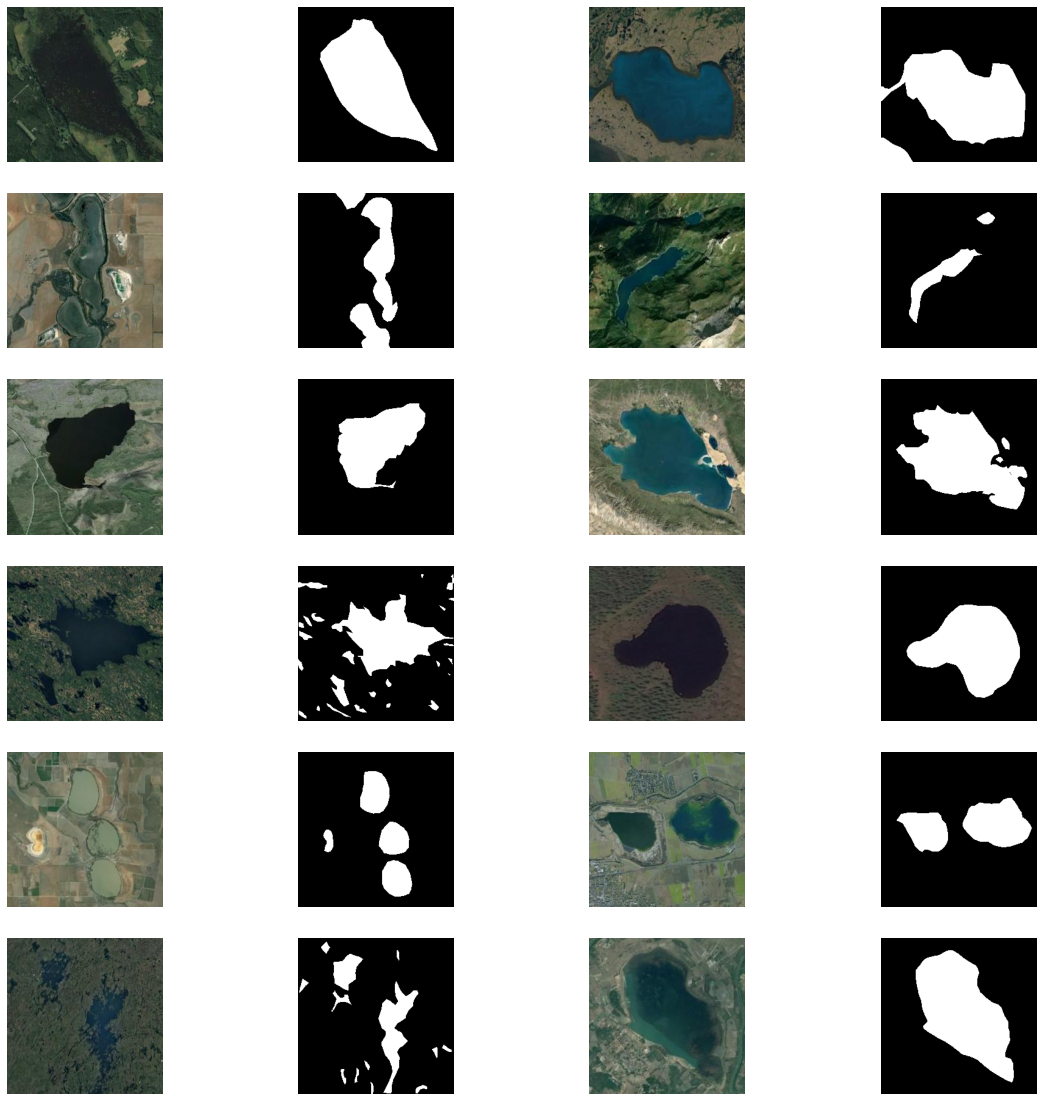

In [38]:
vi, vm = next(val_gen)
plot_batch(vi, vm,  12, 4, figsize=(20,20))

These outputs confirm that I am now able to optionally apply data augmentations successfully to create new training data.